# Housekeeping

## Library imports

In [314]:
from click.formatting import iter_rows

if False:
    import sys
    !{sys.executable} -m pip install -r requirements.txt

In [315]:
# TODO: remove unnecessary packages
import pandas as pd
import numpy as np

import sklearn
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from scipy import stats

from sklearn.model_selection import (
    GridSearchCV,
    RepeatedStratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    roc_auc_score,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

from colorama import Fore, Back, Style

import warnings

import matplotlib.pyplot as plt

## Settings

In [316]:
warnings.filterwarnings("ignore")
sklearn.set_config(transform_output="pandas")
print(Style.RESET_ALL)

## Data imports
Data was manually edited, to convert the mpa411.txt TSV format to a CSV format. Otherwise, Pandas was loading it as a single column, somehow. The first row, containing only "#mpa_vJun23_CHOCOPhlAnSGB_202403" was removed.

In [317]:
data = pd.read_csv('../data/raw/MAI3004_lucki_mpa411.csv')
metadata = pd.read_csv('../data/raw/MAI3004_lucki_metadata_safe.csv')
print(
    f"Data successfully imported. \n shape of data: {data.shape} \n "
    f"Shape of metadata: {metadata.shape}"
)

assert data.shape == (6903, 932), "Data has the wrong shape. Check the CSV formatting."
assert metadata.shape == (930, 6), "Metadata has the wrong shape. Check the CSV formatting."


Data successfully imported. 
 shape of data: (6903, 932) 
 Shape of metadata: (930, 6)


## Function definitions
| Function Name | Description | Parameters |
|---------------|-------------|------------|


# Data preprocessing

## Merge data and metadata

In [318]:
sample_cols = [col for col in data.columns if col.startswith("mpa411_")]

sample_abundances = (
    data[['clade_name'] + sample_cols]
    .set_index('clade_name')
    .transpose()
    .rename_axis('original_sample_id')
    .reset_index()
    .rename(columns={'original_sample_id': 'sample_id'})
)

sample_abundances["sample_id"] = (
    sample_abundances["sample_id"].str.removeprefix(
        "mpa411_",
    )
)

metadata_common = metadata[
    metadata["sample_id"].isin(sample_abundances["sample_id"])
].copy()
merged_samples = metadata_common.merge(
    sample_abundances,
    on="sample_id",
    how="inner",
)

merged_samples.drop(columns=['year_of_birth', 'body_product'], inplace=True)
# YOB and body_product are omitted without sample dates.
# All samples are fecal.
# TODO: should we be accounting for sex? Do statistical analysis

print(f"Metadata rows (original): {metadata.shape[0]}")
print(f"Metadata rows with matching samples: {metadata_common.shape[0]}")
print(
    f"Metadata rows without matching samples: "
    f"{metadata_common.shape[0]-metadata_common.shape[0]}"
)
print(f"Merged dataframe shape: {merged_samples.shape}")

Metadata rows (original): 930
Metadata rows with matching samples: 930
Metadata rows without matching samples: 0
Merged dataframe shape: (930, 6907)


In [319]:
merged_samples.head()

,sample_id,family_id,sex,age_group_at_sample,UNCLASSIFIED,k__Bacteria,k__Bacteria|p__Actinobacteria,k__Bacteria|p__Proteobacteria,k__Bacteria|p__Firmicutes,k__Bacteria|p__Candidatus_Saccharibacteria,...,k__Bacteria|p__Bacteroidota|c__CFGB77857|o__OFGB77857|f__FGB77857|g__GGB12893,k__Bacteria|p__Firmicutes|c__CFGB1778|o__OFGB1778|f__FGB1778|g__GGB4714,k__Bacteria|p__Firmicutes|c__Clostridia|o__Eubacteriales|f__Oscillospiraceae|g__Ruminococcus|s__Ruminococcus_sp_210702_SL_1_03,k__Bacteria|p__Bacteroidota|c__CFGB77857|o__OFGB77857|f__FGB77857|g__GGB12893|s__GGB12893_SGB20033,k__Bacteria|p__Firmicutes|c__CFGB1474|o__OFGB1474|f__FGB1474|g__GGB51269|s__GGB51269_SGB5061,k__Bacteria|p__Firmicutes|c__CFGB1778|o__OFGB1778|f__FGB1778|g__GGB4714|s__GGB4714_SGB6528,k__Bacteria|p__Firmicutes|c__Clostridia|o__Eubacteriales|f__Oscillospiraceae|g__Ruminococcus|s__Ruminococcus_sp_210702_SL_1_03|t__SGB4260,k__Bacteria|p__Bacteroidota|c__CFGB77857|o__OFGB77857|f__FGB77857|g__GGB12893|s__GGB12893_SGB20033|t__SGB20033,k__Bacteria|p__Firmicutes|c__CFGB1474|o__OFGB1474|f__FGB1474|g__GGB51269|s__GGB51269_SGB5061|t__SGB5061,k__Bacteria|p__Firmicutes|c__CFGB1778|o__OFGB1778|f__FGB1778|g__GGB4714|s__GGB4714_SGB6528|t__SGB6528
0,MMHP_Lucki_0001,ENA_fam_0139,female,1-2 weeks,11,88,51,0,34,0,...,0,0,0,0,0,0,0,0,0,0
1,MMHP_Lucki_0002,ENA_fam_0139,female,NaN,13,86,4,0,71,0,...,0,0,0,0,0,0,0,0,0,0
2,MMHP_Lucki_0003,ENA_fam_0136,female,1-2 weeks,20,79,64,10,0,0,...,0,0,0,0,0,0,0,0,0,0
3,MMHP_Lucki_0004,ENA_fam_0136,female,NaN,11,88,11,0,73,0,...,0,0,0,0,0,0,0,0,0,0
4,MMHP_Lucki_0005,ENA_fam_0136,female,4 weeks,21,78,57,18,0,0,...,0,0,0,0,0,0,0,0,0,0


## Encoding

In [320]:
# Sex and family_ID
encoded_samples = merged_samples.copy().dropna(subset="age_group_at_sample")

encoded_samples["sex"] = (
    encoded_samples["sex"]
    .fillna("unknown")
    .replace({"female": 1, "male": 0, "unknown": 2})
)
encoded_samples["family_id"] = LabelEncoder().fit_transform(
    encoded_samples["family_id"]
)


In [321]:
encoding_guide = {
    '1-2 weeks': 1,
    '4 weeks': 2,
    '8 weeks': 3,
    '4 months': 4,
    '5 months': 5,
    '6 months': 6,
    '9 months': 7,
    '11 months': 8,
    '14 months': 9,
}
encoded_samples["age_group_at_sample"].replace(encoding_guide, inplace=True)

In [322]:
if False in pd.DataFrame(encoded_samples["age_group_at_sample"]).applymap(np.isreal): #fallback encoder
    age_encoder = LabelEncoder().fit(encoded_samples["age_group_at_sample"])
    encoded_samples["age_group_at_sample"] = age_encoder.transform(
        encoded_samples["age_group_at_sample"]
    )

    age_groups = dict(
        zip(age_encoder.classes_, age_encoder.transform(age_encoder.classes_))
    )
    print("Age group encoding:", age_groups)

else:
    print("Fallback encoding not needed")

Fallback encoding not needed


## Missing check

In [323]:
missing_table = (
    encoded_samples.isna()
    .sum()
    .to_frame(name="missing_count")
    .assign(
        missing_percent=lambda df: (
            (df["missing_count"] / encoded_samples.shape[0] * 100).round(2)
        ),
    )
    .reset_index()
    .rename(columns={"index": "column"})
    .sort_values("missing_count", ascending=False)
    .query("missing_count != 0")
)

if len(missing_table) > 0:
    missing_table
else:
    print("No missing values detected.")

No missing values detected.


## Outlier check

In [324]:
numeric_cols = encoded_samples.select_dtypes(include=[np.number]).columns

q1 = encoded_samples[numeric_cols].quantile(0.25)
q3 = encoded_samples[numeric_cols].quantile(0.75)
iqr = q3 - q1

lower_bounds = q1 - 1.5 * iqr
upper_bounds = q3 + 1.5 * iqr

outlier_mask = (
    (encoded_samples[numeric_cols] < lower_bounds)
    | (encoded_samples[numeric_cols] > upper_bounds)
)
outlier_counts = outlier_mask.sum()
outlier_percent = (outlier_counts / encoded_samples.shape[0] * 100).round(2)

outlier_table = (
    pd.DataFrame({
        "column": numeric_cols,
        "lower_bound": lower_bounds,
        "upper_bound": upper_bounds,
        "outlier_count": outlier_counts,
        "outlier_percent": outlier_percent,
    })
    .query("outlier_count > 0")
    .sort_values("outlier_percent", ascending=False)
    .reset_index(drop=True)
)

outlier_table

,column,lower_bound,upper_bound,outlier_count,outlier_percent
0,k__Bacteria|p__Firmicutes|c__Clostridia|o__Eub...,0,0,201,24
1,k__Bacteria|p__Actinobacteria|c__Actinomycetia...,0,0,201,24
2,k__Bacteria|p__Verrucomicrobia,0,0,200,24
3,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactob...,0,0,198,24
4,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacill...,0,0,198,24
...,...,...,...,...,...
5155,k__Bacteria|p__Actinobacteria|c__Actinomycetia...,0,0,1,0
5156,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,0,0,1,0
5157,k__Bacteria|p__Firmicutes|c__Clostridia|o__Eub...,0,0,1,0
5158,k__Bacteria|p__Firmicutes|c__Negativicutes|o__...,0,0,1,0


## Normalisation check

In [325]:
normalized_samples = encoded_samples.copy()
print("Shapiro-Wilk Normality Test")

for column in numeric_cols:
    data_nona = normalized_samples[column].dropna()
    stat, p_value = stats.shapiro(data_nona)

    if p_value > 0.05:
        print(Fore.GREEN + f"{column}: Normally Distributed (p={p_value:.4f})")

    else:
        print(
            Fore.RED
            + f"{column}: Not Normally Distributed (p={p_value:.4f})"
        )

print(Style.RESET_ALL)

Shapiro-Wilk Normality Test
family_id: Not Normally Distributed (p=0.0000)
sex: Not Normally Distributed (p=0.0000)
age_group_at_sample: Not Normally Distributed (p=0.0000)
UNCLASSIFIED: Not Normally Distributed (p=0.0000)
k__Bacteria: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Actinobacteria: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Proteobacteria: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Firmicutes: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Candidatus_Saccharibacteria: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Bacteroidota: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Actinobacteria|c__Actinomycetia: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Firmicutes|c__Negativicutes: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Firmicutes|c__Clostridia: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Firmicutes|c__Bacilli: Not Normally Dist

In [326]:
#TODO: consider normalising the data, if the model requires it

# Exploratory data analysis

In [327]:
print(merged_samples.shape)
merged_samples.head()

(930, 6907)


,sample_id,family_id,sex,age_group_at_sample,UNCLASSIFIED,k__Bacteria,k__Bacteria|p__Actinobacteria,k__Bacteria|p__Proteobacteria,k__Bacteria|p__Firmicutes,k__Bacteria|p__Candidatus_Saccharibacteria,...,k__Bacteria|p__Bacteroidota|c__CFGB77857|o__OFGB77857|f__FGB77857|g__GGB12893,k__Bacteria|p__Firmicutes|c__CFGB1778|o__OFGB1778|f__FGB1778|g__GGB4714,k__Bacteria|p__Firmicutes|c__Clostridia|o__Eubacteriales|f__Oscillospiraceae|g__Ruminococcus|s__Ruminococcus_sp_210702_SL_1_03,k__Bacteria|p__Bacteroidota|c__CFGB77857|o__OFGB77857|f__FGB77857|g__GGB12893|s__GGB12893_SGB20033,k__Bacteria|p__Firmicutes|c__CFGB1474|o__OFGB1474|f__FGB1474|g__GGB51269|s__GGB51269_SGB5061,k__Bacteria|p__Firmicutes|c__CFGB1778|o__OFGB1778|f__FGB1778|g__GGB4714|s__GGB4714_SGB6528,k__Bacteria|p__Firmicutes|c__Clostridia|o__Eubacteriales|f__Oscillospiraceae|g__Ruminococcus|s__Ruminococcus_sp_210702_SL_1_03|t__SGB4260,k__Bacteria|p__Bacteroidota|c__CFGB77857|o__OFGB77857|f__FGB77857|g__GGB12893|s__GGB12893_SGB20033|t__SGB20033,k__Bacteria|p__Firmicutes|c__CFGB1474|o__OFGB1474|f__FGB1474|g__GGB51269|s__GGB51269_SGB5061|t__SGB5061,k__Bacteria|p__Firmicutes|c__CFGB1778|o__OFGB1778|f__FGB1778|g__GGB4714|s__GGB4714_SGB6528|t__SGB6528
0,MMHP_Lucki_0001,ENA_fam_0139,female,1-2 weeks,11,88,51,0,34,0,...,0,0,0,0,0,0,0,0,0,0
1,MMHP_Lucki_0002,ENA_fam_0139,female,NaN,13,86,4,0,71,0,...,0,0,0,0,0,0,0,0,0,0
2,MMHP_Lucki_0003,ENA_fam_0136,female,1-2 weeks,20,79,64,10,0,0,...,0,0,0,0,0,0,0,0,0,0
3,MMHP_Lucki_0004,ENA_fam_0136,female,NaN,11,88,11,0,73,0,...,0,0,0,0,0,0,0,0,0,0
4,MMHP_Lucki_0005,ENA_fam_0136,female,4 weeks,21,78,57,18,0,0,...,0,0,0,0,0,0,0,0,0,0


In [328]:
# Dataset overview
print("Number of samples:", len(merged_samples))
print(
    "Number of unique families (family_id):",
    merged_samples["family_id"].nunique(),
)
print("Number of columns (metadata + features):", merged_samples.shape[1])

Number of samples: 930
Number of unique families (family_id): 139
Number of columns (metadata + features): 6907


In [329]:
# Samples per family
samples_per_family = merged_samples["family_id"].value_counts()
samples_per_family.describe()

count   139
mean      6
std       2
min       1
25%       5
50%       7
75%       8
max      11
Name: count, dtype: float64

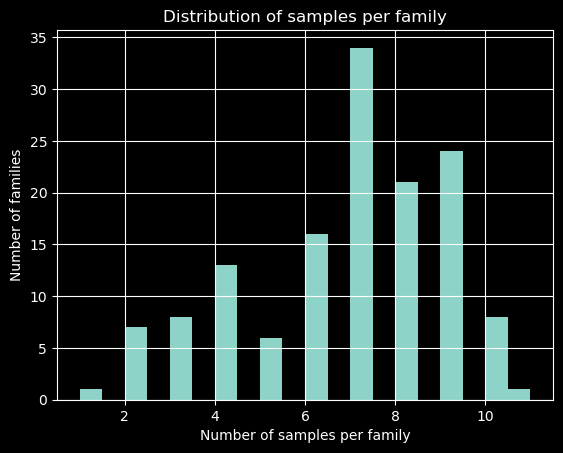

In [330]:
samples_per_family.hist(bins=20)
plt.xlabel("Number of samples per family")
plt.ylabel("Number of families")
plt.title("Distribution of samples per family")
plt.show()

In [331]:
#distribution of age groups
merged_samples["age_group_at_sample"].value_counts(dropna=False)

age_group_at_sample
NaN          122
8 weeks      105
4 months     103
5 months      96
9 months      92
6 months      88
1-2 weeks     84
11 months     83
4 weeks       82
14 months     75
Name: count, dtype: int64

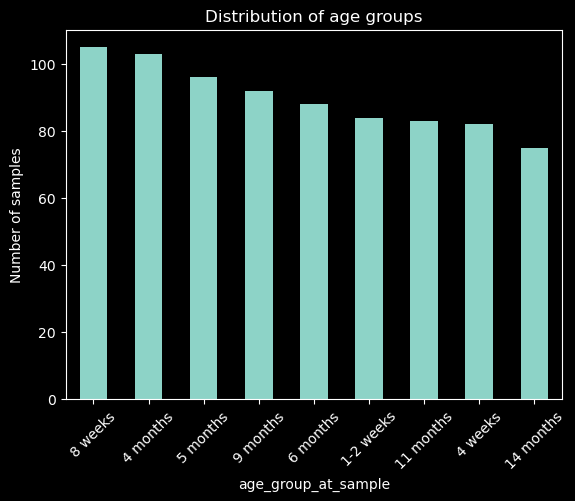

In [332]:
merged_samples["age_group_at_sample"].value_counts().plot(kind="bar")
plt.title("Distribution of age groups")
plt.ylabel("Number of samples")
plt.xticks(rotation=45)
plt.show()

In [333]:
#dimensionality and sparsity of the microbiome feature matrix
metadata_cols = [
    "sample_id",
    "family_id",
    "sex",
    "body_product",
    "age_group_at_sample",
    "year_of_birth",
]
feature_cols = [c for c in merged_samples.columns if c not in metadata_cols]

X = merged_samples[feature_cols]

print("Feature matrix shape:", X.shape)
print("Overall fraction of zeros:", (X == 0).mean().mean())

Feature matrix shape: (930, 6903)
Overall fraction of zeros: 0.9556136571445484


In [334]:
#number of observed taxa per sample
nonzero_per_sample = (X > 0).sum(axis=1)
nonzero_per_sample.describe()

count    930
mean     306
std      338
min       46
25%      127
50%      181
75%      282
max     1821
dtype: float64

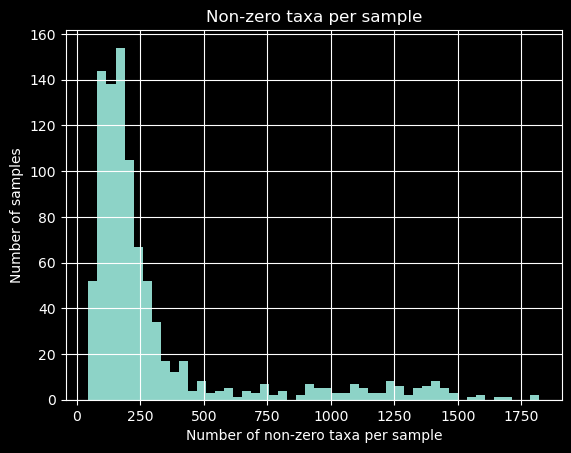

In [335]:
nonzero_per_sample.hist(bins=50)
plt.xlabel("Number of non-zero taxa per sample")
plt.ylabel("Number of samples")
plt.title("Non-zero taxa per sample")
plt.show()

In [336]:
# Total abundance per sample (sanity check)
total_abundance = X.sum(axis=1)
total_abundance.describe()

count   930
mean    704
std      64
min     337
25%     676
50%     715
75%     749
max     800
dtype: float64

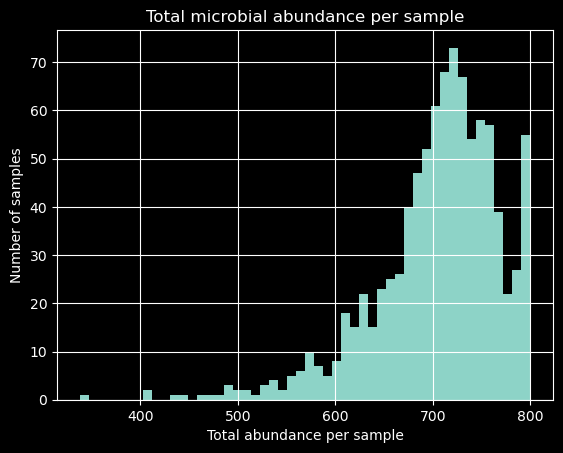

In [337]:
total_abundance.hist(bins=50)
plt.xlabel("Total abundance per sample")
plt.ylabel("Number of samples")
plt.title("Total microbial abundance per sample")
plt.show()

In [338]:
# Distribution of feature prevalence
feature_prevalence = (X > 0).sum(axis=0)
feature_prevalence.describe()

count   6903
mean      41
std       96
min        1
25%        2
50%        9
75%       38
max      930
dtype: float64

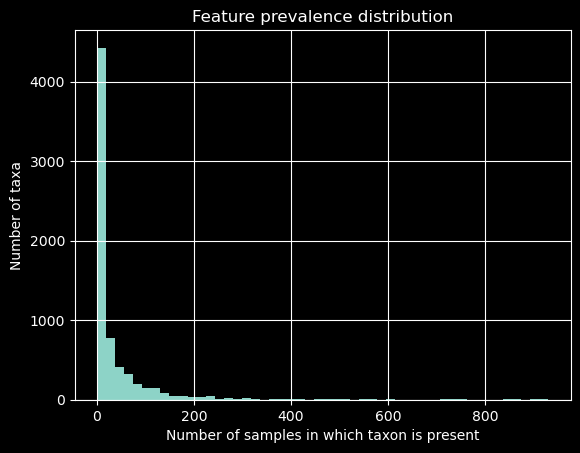

In [339]:
feature_prevalence.hist(bins=50)
plt.xlabel("Number of samples in which taxon is present")
plt.ylabel("Number of taxa")
plt.title("Feature prevalence distribution")
plt.show()

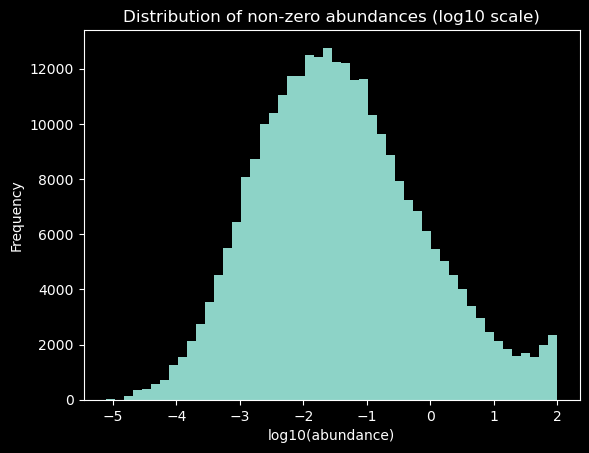

In [340]:
# Distribution of non-zero abundances (log scale)

nonzero_values = X.values[X.values > 0]
plt.hist(np.log10(nonzero_values), bins=50)
plt.xlabel("log10(abundance)")
plt.ylabel("Frequency")
plt.title("Distribution of non-zero abundances (log10 scale)")
plt.show()

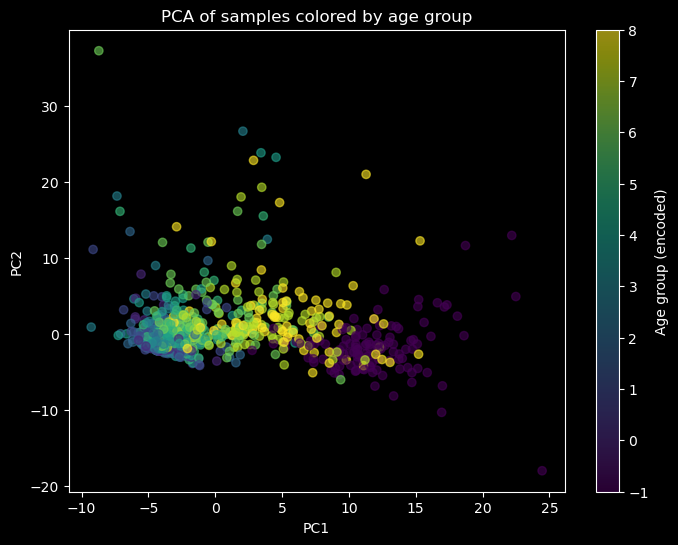

Explained variance ratio: [0.07115835 0.02969296]


In [341]:
# PCA visualization
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Use a subset of features for speed
prevalence = (X > 0).sum(axis=0)
top_features = prevalence.sort_values(ascending=False).head(500).index

X_sub = X[top_features]

# Scale features
X_scaled = StandardScaler().fit_transform(X_sub)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot
age = merged_samples["age_group_at_sample"]

plt.figure(figsize=(8,6))
plt.scatter(X_pca.iloc[:, 0], X_pca.iloc[:, 1],
            c=pd.factorize(age)[0], cmap="viridis", alpha=0.6)
plt.colorbar(label="Age group (encoded)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of samples colored by age group")
plt.show()

print("Explained variance ratio:", pca.explained_variance_ratio_)

### Summary of EDA
The dataset consists of 930 stool samples derived from multiple individuals across different families and contains approximately 6,900 microbiome features, making it a high-dimensional and highly sparse dataset. Each sample contains on average around 300 detected taxa, while the total microbial abundance per sample is relatively stable, indicating that sequencing depth is consistent across samples.
Most taxa are rare and occur in only a small fraction of samples, whereas a small subset of taxa is highly prevalent across the cohort. The distribution of non-zero abundances follows an approximately log-normal shape, which is typical for microbiome sequencing data (e.g., Lutz et al., 2022).
A PCA projection based on the most prevalent taxa does not reveal sharply separated clusters but shows a gradual age-related gradient, suggesting that age-related variation in microbiome composition is present but represents only a limited fraction of the total variance in the data.